# Basic Experiments

This notebook demonstrates some qubit tuneup experiments, which can be used as template to create more advanced sequences.
Please check out the [single qubit tuneup](https://github.com/zhinst/laboneq/blob/main/examples/single_qubit_tuneup.ipynb) notebook for an example of how to set up a tune-up sequence and use experimental results.

In [1]:
# LabOne Q:
from laboneq.simple import *

# Helpers:
from laboneq.contrib.example_helpers.plotting.plot_helpers import *
from laboneq.contrib.example_helpers.example_notebook_helper import create_device_setup

In [2]:
# create device setup
device_setup = create_device_setup(generation=2)
use_emulation = True

<div class="alert alert-block alert-info">
<b>Remark:</b> The spectroscopy experiments in this notebook rely on the real-time frequency sweep functionality of the Zurich Instruments SHF-line devices. [Another example notebook](https://github.com/zhinst/laboneq/blob/main/examples/spectroscopy_uhfqa_hdawg.ipynb) explains how to run spectroscopy experiments also with the UHFQA (resonator spectroscopy) and HDAWG (qubit spectroscopy).</div>

## 1. CW Resonator Spectroscopy

Find the resonance frequency of the qubit readout resonator by looking at the transmission or reflection of a probe signal applied through the readout line.

### 1.1 Define the Experiment

In [3]:
# define sweep parameter - sweep over frequency of readout pulse
start = -700e6
stop = 700e6
count = 21

frequency_sweep_parameter = LinearSweepParameter(
    uid="frequency_sweep", start=start, stop=stop, count=count
)

# define number of averages
average_exponent = 4  # used for 2^n averages, n=average_exponent, maximum: n = 17

# Create Experiment - uses only a readout pulse and a data acquisition line
exp = Experiment(
    uid="Resonator Spectroscopy",
    signals=[
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)

## experimental pulse sequence
# Define an acquisition loop of type SPECTROSCOPY
with exp.acquire_loop_rt(
    uid="shots",
    count=pow(2, average_exponent),
    averaging_mode=AveragingMode.SEQUENTIAL,
    acquisition_type=AcquisitionType.SPECTROSCOPY,
):
    with exp.sweep(uid="sweep", parameter=frequency_sweep_parameter):
        # readout pulse and data acquisition
        with exp.section(uid="spectroscopy"):
            exp.acquire(
                signal="acquire",
                handle="ac_0",
                length=15e-6,
            )
        # relax time after readout - for signal processing and qubit relaxation to ground state
        with exp.section(uid="relax", play_after="spectroscopy"):
            exp.delay(signal="acquire", time=1e-6)

In [4]:
# calibration for qubit 0
# The start of acquisition is delayed by 250 ns to compensate for the reference signal propagation within the SHFQA.
exp_calib = Calibration()
exp_calib["acquire"] = SignalCalibration(
    oscillator=Oscillator(
        frequency=frequency_sweep_parameter,
        modulation_type=ModulationType.HARDWARE,
    ),
    port_delay=250e-9,
)

In [5]:
# signal map for qubit 0


def map_qubit(qubit_id):
    return {
        "measure": f"/logical_signal_groups/q{qubit_id}/measure_line",
        "acquire": f"/logical_signal_groups/q{qubit_id}/acquire_line",
    }

### 1.2 Run the Experiment and Plot the Measurement Results

[2023.10.09 11:38:50.005] INFO    Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is u:\LabOneQ Software Local Samuel\laboneq\examples\01_qubit_characterization\laboneq_output\log
[2023.10.09 11:38:50.014] INFO    VERSION: laboneq 2.15.0
[2023.10.09 11:38:50.018] INFO    Connecting to data server at my_ip_address:8004
[2023.10.09 11:38:50.024] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at my_ip_address:8004
[2023.10.09 11:38:50.054] INFO    Configuring the device setup
[2023.10.09 11:38:50.196] INFO    The device setup is configured
[2023.10.09 11:38:50.212] INFO    VERSION: laboneq 2.15.0
[2023.10.09 11:38:50.216] INFO    Connecting to data server at my_ip_address:8004
[2023.10.09 11:38:50.221] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at my_ip_address:8004
[2023.10.09 11:38:50.239] INFO    Configuring the device setup
[2023.10.09 11:38:50.285] INFO    The device setup is configu

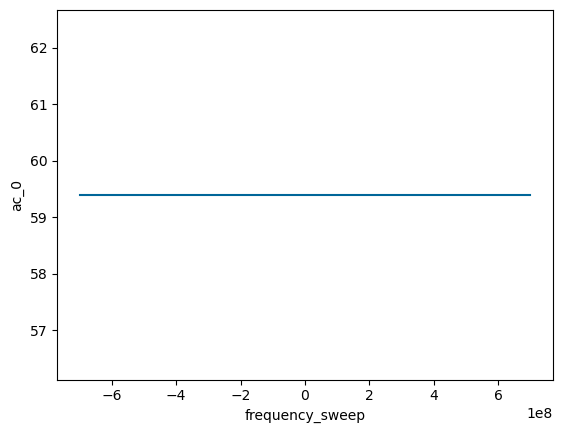

In [6]:
# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# set experiment calibration and signal map
exp.set_calibration(exp_calib)
exp.set_signal_map(map_qubit(0))

# run experiment
my_results = session.run(exp)

# plot measurement results
plot_result_2d(my_results, "ac_0")

In [7]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("Resonator Spectroscopy", session.compiled_experiment)

[2023.10.09 11:38:53.661] INFO    Requesting more events for the PSV than currently published, recompiling experiment
[2023.10.09 11:38:53.674] INFO    VERSION: laboneq 2.15.0
[2023.10.09 11:38:53.676] INFO    Connecting to data server at my_ip_address:8004
[2023.10.09 11:38:53.679] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at my_ip_address:8004
[2023.10.09 11:38:53.695] INFO    Configuring the device setup
[2023.10.09 11:38:53.754] INFO    The device setup is configured
[2023.10.09 11:38:53.764] INFO    Starting LabOne Q Compiler run...
[2023.10.09 11:38:53.773] INFO    Schedule completed
[2023.10.09 11:38:53.812] INFO    Finished LabOne Q Compiler run.
[2023.10.09 11:38:53.987] INFO    Writing html file to u:\LabOneQ Software Local Samuel\laboneq\examples\01_qubit_characterization\Resonator Spectroscopy_2023-10-09-11-38-53.html


u:\LabOneQ Software Local Samuel\laboneq\examples\01_qubit_characterization\Resonator Spectroscopy_2023-10-09-11-38-53.html

In [8]:
# Run the same experiment on qubit 1
exp.set_calibration(exp_calib)
exp.set_signal_map(map_qubit(1))
my_results = session.run(exp)

[2023.10.09 11:38:56.802] INFO    VERSION: laboneq 2.15.0
[2023.10.09 11:38:56.811] INFO    Connecting to data server at my_ip_address:8004
[2023.10.09 11:38:56.813] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at my_ip_address:8004
[2023.10.09 11:38:56.836] INFO    Configuring the device setup
[2023.10.09 11:38:56.894] INFO    The device setup is configured
[2023.10.09 11:38:56.901] INFO    Starting LabOne Q Compiler run...
[2023.10.09 11:38:56.913] INFO    Schedule completed
[2023.10.09 11:38:56.934] INFO     ────────────────────────────────────────────────────────────────── 
[2023.10.09 11:38:56.939] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2023.10.09 11:38:56.941] INFO     ────────────────────────────────────────────────────────────────── 
[2023.10.09 11:38:56.943] INFO      device_shfqa     0         23            0           0         0  
[2023.10.09 11:38:56.945] INFO     ───────────────────────────────────────────

## 2. Pulsed Qubit Spectroscopy

Find the resonance frequency of the qubit by looking at the change in resonator transmission when sweeping the frequency of a qubit excitation pulse.

### 2.1 Define the Experiment

In [ ]:
## define pulses

# qubit drive pulse
const_iq_100ns = pulse_library.const(uid="const_iq_100ns", length=100e-9, amplitude=1.0)
# readout drive pulse
readout_pulse = pulse_library.const(uid="readout_pulse", length=400e-9, amplitude=1.0)
# readout weights for integration
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=200e-9, amplitude=1.0
)

In [ ]:
# define sweep parameter - sweep over the frequency of a qubit excitation pulse
start = 40e6
stop = 200e6
count = 21

drive_frequency_sweep = LinearSweepParameter(
    uid="qubit_freq", start=start, stop=stop, count=count
)

# define number of averages
average_exponent = 4  # used for 2^n averages, n=average_exponent, maximum: n = 17

# Create Experiment - no explicit mapping to qubit lines
exp = Experiment(
    uid="Qubit Spectroscopy",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)
## experimental pulse sequence
with exp.acquire_loop_rt(
    uid="shots",
    count=pow(2, average_exponent),
    averaging_mode=AveragingMode.SEQUENTIAL,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(uid="sweep", parameter=drive_frequency_sweep):
        # qubit excitation pulse - frequency will be swept
        with exp.section(uid="qubit_excitation", alignment=SectionAlignment.RIGHT):
            exp.play(signal="drive", pulse=const_iq_100ns)
        # readout and data acquisition
        with exp.section(uid="qubit_readout", play_after="qubit_excitation"):
            # play readout pulse
            exp.play(signal="measure", pulse=readout_pulse)
            # signal data acquisition
            exp.acquire(
                signal="acquire",
                handle="ac_0",
                kernel=readout_weighting_function,
            )
        # relax time after readout - for signal processing and qubit relaxation to ground state
        with exp.section(uid="relax", play_after="qubit_readout"):
            exp.delay(signal="measure", time=1e-6)

In [ ]:
# define experiment calibration - sweep over qubit drive frequency
exp_calib = Calibration()
exp_calib["drive"] = SignalCalibration(
    oscillator=Oscillator(
        frequency=drive_frequency_sweep,
        modulation_type=ModulationType.HARDWARE,
    )
)

In [ ]:
def map_qubit(qubit_id):
    return {
        "drive": device_setup.logical_signal_groups[f"q{qubit_id}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"q{qubit_id}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"q{qubit_id}"].logical_signals[
            "acquire_line"
        ],
    }

### 2.2 Run the Experiment and Plot the Measurement Results and Pulse Sequence

In [ ]:
# set calibration and signal map for qubit 0
exp.set_calibration(exp_calib)
exp.set_signal_map(map_qubit(0))

# create a session and connect to it
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run experiment on qubit 0
my_results = session.run(exp)

In [ ]:
# Plot simulated output signals
plot_simulation(session.compiled_experiment, 0, 10e-6)

In [ ]:
# plot measurement results
plot_result_2d(my_results, "ac_0")

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("Qubit Spectroscopy", session.compiled_experiment)

## 3. Amplitude Rabi Experiment

Sweep the pulse amplitude of a qubit drive pulse to determine the ideal amplitudes for specific qubit rotation angles.

### 3.1 Define the Experiment

In [ ]:
## define pulses

# qubit drive pulse - unit amplitude, but will be scaled with sweep parameter
x90 = pulse_library.gaussian(uid="x90", length=100e-9, amplitude=1.0)

# readout drive pulse
readout_pulse = pulse_library.const(uid="readout_pulse", length=400e-9, amplitude=1.0)
# readout integration weights
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=400e-9, amplitude=1.0
)

In [ ]:
# set up sweep parameter - drive amplitude
start = 0.1
stop = 1
count = 10
sweep_parameter = LinearSweepParameter(
    uid="amplitude", start=start, stop=stop, count=count
)

# number of averages
average_exponent = 1  # used for 2^n averages, n=average_exponent, maximum: n = 17

# Create Experiment
exp = Experiment(
    uid="Amplitude Rabi",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)
## experimental pulse sequence
# outer loop - real-time, cyclic averaging in standard integration mode
with exp.acquire_loop_rt(
    uid="shots",
    count=pow(2, average_exponent),
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    # inner loop - real-time sweep of qubit drive pulse amplitude
    with exp.sweep(
        uid="sweep", parameter=sweep_parameter, alignment=SectionAlignment.RIGHT
    ):
        # qubit excitation - pulse amplitude will be swept
        with exp.section(uid="qubit_excitation", alignment=SectionAlignment.RIGHT):
            exp.play(signal="drive", pulse=x90, amplitude=sweep_parameter)
        # qubit readout pulse and data acquisition
        with exp.section(uid="qubit_readout", play_after="qubit_excitation"):
            # play readout pulse
            exp.play(signal="measure", pulse=readout_pulse)
            # signal data acquisition
            exp.acquire(
                signal="acquire",
                handle="ac_0",
                kernel=readout_weighting_function,
            )
        # relax time after readout - for signal processing and qubit relaxation to ground state
        with exp.section(uid="relax", play_after="qubit_readout"):
            exp.delay(signal="measure", time=1e-6)

In [ ]:
def map_qubit(qubit_id):
    return {
        "drive": device_setup.logical_signal_groups[f"q{qubit_id}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"q{qubit_id}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"q{qubit_id}"].logical_signals[
            "acquire_line"
        ],
    }

### 3.2 Run the Experiment and Plot the Measurement Results and Pulse Sequence

In [ ]:
# set signal map to qubit 0
exp.set_signal_map(map_qubit(0))

# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run experiment on qubit 0
my_results = session.run(exp)

In [ ]:
# Plot simulated output signals
plot_simulation(session.compiled_experiment, 0, 10e-6)

In [ ]:
# plot measurement results
plot_result_2d(my_results, "ac_0")

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("Amplitude Rabi", session.compiled_experiment)

In [ ]:
# set signal map to qubit 1
exp.set_signal_map(map_qubit(1))

# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run experiment on qubit 1
my_results = session.run(exp)

## 4. Length Rabi Experiment

Instead of sweeping the amplitude of the drive pulse as above, we can also sweep its length.

### 4.1 Define the Experiment

In [ ]:
## define pulses

# qubit drive pulse - unit amplitude, but will be scaled with sweep parameter
x90 = pulse_library.gaussian(uid="x90", length=100e-9, amplitude=1.0)
# readout drive pulse
readout_pulse = pulse_library.const(uid="readout_pulse", length=400e-9, amplitude=1.0)
# readout integration weights
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=400e-9, amplitude=1.0
)

In [ ]:
# set up sweep parameter - drive pulse length
start = 30e-9
stop = 200e-9
count = 11
length_sweep = LinearSweepParameter(uid="length", start=start, stop=stop, count=count)

# number of averages
average_exponent = 1  # used for 2^n averages, n=average_exponent, maximum: n = 17

# Create Experiment
exp = Experiment(
    uid="Length Rabi",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)
## experimental pulse sequence
# outer loop - real-time, cyclic averaging in standard integration mode
with exp.acquire_loop_rt(
    uid="shots",
    count=pow(2, average_exponent),
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
    repetition_mode=RepetitionMode.AUTO,  # the compiler determines the optimal shot repetition rate
):
    # inner loop - real-time sweep of qubit drive pulse amplitude
    with exp.sweep(
        uid="sweep", parameter=length_sweep, alignment=SectionAlignment.RIGHT
    ):
        # qubit excitation - pulse length will be swept
        with exp.section(uid="qubit_excitation", alignment=SectionAlignment.RIGHT):
            exp.play(signal="drive", pulse=x90, length=length_sweep)
        # qubit readout pulse and data acquisition
        with exp.section(uid="qubit_readout", play_after="qubit_excitation"):
            # play readout pulse
            exp.play(signal="measure", pulse=readout_pulse)
            # signal data acquisition
            exp.acquire(
                signal="acquire",
                handle="ac_0",
                kernel=readout_weighting_function,
            )
        # relax time after readout - for signal processing and qubit relaxation to ground state
        with exp.section(uid="relax", play_after="qubit_readout"):
            exp.delay(signal="measure", time=1e-6)

### 4.2 Run the Experiment and Plot the Measurement Results and Pulse Sequence

In [ ]:
# set signal map to qubit 0
exp.set_signal_map(map_qubit(0))

# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run experiment on qubit 0
my_results = session.run(exp)

In [ ]:
# Plot simulated output signals
plot_simulation(session.compiled_experiment, 0, 10e-6)

In [ ]:
# plot measurement results
plot_result_2d(my_results, "ac_0")

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("Length Rabi", session.compiled_experiment)

In [ ]:
# set signal map to qubit 1
exp.set_signal_map(map_qubit(1))

# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run experiment on qubit 1
my_results = session.run(exp)

## 5. Ramsey Experiment

Sweep the delay between two slightly detuned pi/2 pulses to determine the qubit dephasing time as well as fine calibration its excited state frequency

### 5.1 Define the Experiment

In [ ]:
## define pulses

# qubit drive pulse - use amplitude calibrated by amplitude Rabi experiment
x90 = pulse_library.gaussian(uid="x90", length=100e-9, amplitude=0.66)
# readout drive pulse
readout_pulse = pulse_library.const(uid="readout_pulse", length=400e-9, amplitude=1.0)
# readout integration weights
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=400e-9, amplitude=1.0
)

In [ ]:
# set up sweep parameter - delay between pi/2 pulses
start = 0.0
stop = 1000e-9
count = 10

delay_sweep = LinearSweepParameter(uid="delay", start=start, stop=stop, count=count)

# number of averages
average_exponent = 1  # used for 2^n averages, n=average_exponent, maximum: n = 17

# Create Experiment
exp = Experiment(
    uid="Ramsey",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)
## experimental pulse sequence
# outer loop - real-time, cyclic averaging in standard integration mode
with exp.acquire_loop_rt(
    uid="shots",
    count=pow(2, average_exponent),
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    # inner loop - real-time sweep over delay between qubit pulses
    with exp.sweep(
        uid="sweep", parameter=delay_sweep, alignment=SectionAlignment.RIGHT
    ):
        # qubit drive pulses - use right-aligned, constant length section to optimize overall experimental sequence
        # another way of implementation with a right-aligned sweep section and repetition time AUTO is shown in T1 experiment below
        with exp.section(
            uid="qubit_excitation",
            length=stop + 2 * x90.length,
            alignment=SectionAlignment.RIGHT,
        ):
            exp.play(signal="drive", pulse=x90)
            exp.delay(signal="drive", time=delay_sweep)
            exp.play(signal="drive", pulse=x90)
        # qubit readout pulse and data acquisition
        with exp.section(uid="qubit_readout", play_after="qubit_excitation"):
            # play readout pulse
            exp.play(signal="measure", pulse=readout_pulse)
            # signal data acquisition
            exp.acquire(
                signal="acquire",
                handle="ac_0",
                kernel=readout_weighting_function,
            )
        # relax time after readout - for signal processing and qubit relaxation to ground state
        with exp.section(uid="relax", play_after="qubit_readout"):
            exp.delay(signal="measure", time=1e-6)

In [ ]:
# define signal maps for qubit 0
map_q0 = {
    "drive": device_setup.logical_signal_groups["q0"].logical_signals["drive_line"],
    "measure": device_setup.logical_signal_groups["q0"].logical_signals["measure_line"],
    "acquire": device_setup.logical_signal_groups["q0"].logical_signals["acquire_line"],
}

### 5.2 Run the Experiment and Plot the Measurement Results and Pulse Sequence

In [ ]:
# map exp to qubit 0
exp.set_signal_map(map_qubit(0))

# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run on qubit 0
my_results = session.run(exp)

In [ ]:
# Plot simulated output signals
plot_simulation(session.compiled_experiment, 0, 10e-6)

In [ ]:
# plot measurement results
plot_result_2d(my_results, "ac_0")

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("Ramsey", session.compiled_experiment)

In [ ]:
# map exp to qubit 1
exp.set_signal_map(map_qubit(1))

# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run on qubit 1
my_results = session.run(exp)

## 6. T1 Experiment

Sweep the delay between a qubit excitation pulse and the readout to measure the energy relaxation time of the qubit

### 6.1 Define the Experiment

In [ ]:
## define pulses

# qubit drive pulse - use amplitude calibrated by amplitude Rabi experiment
x180 = pulse_library.gaussian(uid="x180", length=100e-9, amplitude=0.66)
# readout drive pulse
readout_pulse = pulse_library.const(uid="readout_pulse", length=400e-9, amplitude=1.0)
# readout integration weights
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=400e-9, amplitude=1.0
)

In [ ]:
# sweep parameter - delay before readout / after pi pulse
count = 11
start = 0
stop = 1e-6
delay_sweep = LinearSweepParameter(uid="delay", start=start, stop=stop, count=count)

# number of averages
average_exponent = 4  # used for 2^n averages, n=average_exponent, maximum: n = 17

# Create Experiment
exp = Experiment(
    uid="T1 experiment",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)
## experimental pulse sequence
# outer loop - real-time, cyclic averaging in standard integration mode
with exp.acquire_loop_rt(
    uid="shots",
    count=pow(2, average_exponent),
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
    repetition_mode=RepetitionMode.AUTO,  # compiler sets repetition time to shortest possible constant time
):
    # inner loop - sweep over delay between qubit excitation and readout pulse
    # right alignment makes sure the readout section follows a fixed timing, being the last element in each shot
    with exp.sweep(
        uid="sweep", parameter=delay_sweep, alignment=SectionAlignment.RIGHT
    ):
        # qubit drive pulse followed by variable delay
        with exp.section(uid="qubit_excitation", alignment=SectionAlignment.RIGHT):
            exp.play(signal="drive", pulse=x180)
            exp.delay(signal="drive", time=delay_sweep)
        # qubit readout pulse and data acquisition
        with exp.section(uid="qubit_readout", play_after="qubit_excitation"):
            # play readout pulse
            exp.play(signal="measure", pulse=readout_pulse)
            # signal data acquisition
            exp.acquire(
                signal="acquire",
                handle="ac_0",
                kernel=readout_weighting_function,
            )
        # relax time after readout - for signal processing and qubit relaxation to ground state
        with exp.section(uid="relax", play_after="qubit_readout"):
            exp.delay(signal="measure", time=1e-6)

In [ ]:
# define signal maps for qubit 0
map_q0 = {
    "drive": device_setup.logical_signal_groups["q0"].logical_signals["drive_line"],
    "measure": device_setup.logical_signal_groups["q0"].logical_signals["measure_line"],
    "acquire": device_setup.logical_signal_groups["q0"].logical_signals["acquire_line"],
}

### 6.2 Run the Experiment and Plot the Measurement Results and Pulse Sequence

In [ ]:
# map exp to qubit 0
exp.set_signal_map(map_qubit(0))

# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run on qubit 0
my_results = session.run(exp)

In [ ]:
# Plot simulated output signals
plot_simulation(session.compiled_experiment, 0, 10e-6)

In [ ]:
# plot measurement results
plot_result_2d(my_results, "ac_0")

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("T1", session.compiled_experiment)

In [ ]:
# map exp to qubit 1
exp.set_signal_map(map_qubit(1))

# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run on qubit 1
my_results = session.run(exp)

## 7. Ramsey with Sampled Pulse Definition

Sweep the delay between two slightly detuned pi/2 pulses to determine the qubit dephasing time as well as fine calibration its excited state frequency.

Here use a user defined pulse, given as complex valued numpy array.

### 7.1 Pulse definition

In [ ]:
## define pulses
drive_sampling_rate = 2.0e9  # A setup consisting of SHF instruments and HDAWGs has a sampling rate of 2 GSa/s

# qubit drive pulse as sampled complex pulse
x90_length = 100e-9
num_samples = round((x90_length * drive_sampling_rate))
samples_complex = np.transpose(
    np.array(
        [
            np.arange(num_samples) * (1 / num_samples),
            np.arange(num_samples) * (1 / num_samples),
        ]
    )
)

x90 = pulse_library.sampled_pulse_complex(samples=samples_complex, uid="x90")
# readout drive pulse
readout_pulse = pulse_library.const(uid="readout_pulse", length=400e-9, amplitude=1.0)
# readout integration weights
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=200e-9, amplitude=1.0
)

### 7.2 Define the Experiment

In [ ]:
# set up sweep parameter - delay between pi/2 pulses
start = 0.0
stop = 1000e-9
count = 11

delay_sweep = LinearSweepParameter(uid="delay", start=start, stop=stop, count=count)

# number of averages
average_exponent = 1  # used for 2^n averages, n=average_exponent, maximum: n = 17

# Create Experiment
exp = Experiment(
    uid="Ramsey",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)
## experimental sequence
# outer loop - real-time, cyclic averaging in standard integration mode
with exp.acquire_loop_rt(
    uid="shots",
    count=pow(2, average_exponent),
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    # inner loop - sweep over delay between qubit drive pulses
    with exp.sweep(
        uid="sweep", parameter=delay_sweep, alignment=SectionAlignment.RIGHT
    ):
        # qubit excitation pulses - use right-aligned, constant length section to optimize pulse timings
        with exp.section(
            uid="qubit_excitation",
            length=stop + 2 * x90_length,
            alignment=SectionAlignment.RIGHT,
        ):
            exp.play(signal="drive", pulse=x90)
            exp.delay(signal="drive", time=delay_sweep)
            exp.play(signal="drive", pulse=x90)
        # qubit readout pulse and data acquisition
        with exp.section(uid="qubit_readout", play_after="qubit_excitation"):
            # play readout pulse
            exp.play(signal="measure", pulse=readout_pulse)
            # signal data acquisition
            exp.acquire(
                signal="acquire",
                handle="ac_0",
                kernel=readout_weighting_function,
            )
        # relax time after readout - for signal processing and qubit relaxation to ground state
        with exp.section(uid="relax", play_after="qubit_readout"):
            exp.delay(signal="measure", time=1e-6)

###  7.3 Run the Experiment and Plot the Measurement Results and Pulse Sequence

In [ ]:
# map exp to qubit 0
exp.set_signal_map(map_qubit(0))

# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run on qubit 0
my_results = session.run(exp)

In [ ]:
# Plot simulated output signals
plot_simulation(session.compiled_experiment, 0, 10e-6)

In [ ]:
# plot measurement results
plot_result_2d(my_results, "ac_0")

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("T1", session.compiled_experiment)

In [ ]:
# map exp to qubit 1
exp.set_signal_map(map_qubit(1))

# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run on qubit 1
my_results = session.run(exp)

## 8. Pulsed Qubit Spectroscopy for Flux-Dependent Qubit

Determine the flux-dependent resonance frequency of a qubit by investigating the change in resonator transmission when sweeping the frequency of a qubit excitation pulse

### 8.1 Define the Experiment

In [ ]:
## define pulses

# flux pulse - applied during whole experimental pulse sequence
const_flux = pulse_library.const(uid="const_flux", length=600e-9, amplitude=1.0)
# qubit drive pulse
const_iq_100ns = pulse_library.const(uid="const_iq_100ns", length=100e-9, amplitude=1.0)
# readout drive pulse
readout_pulse = pulse_library.const(uid="readout_pulse", length=400e-9, amplitude=1.0)
# readout weights for integration
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=400e-9, amplitude=1.0
)

In [ ]:
# define sweep parameter - sweep over the frequency of a qubit excitation pulse
start = 40e6
stop = 200e6
count = 11

freq_sweep = LinearSweepParameter(uid="freq-qubit", start=start, stop=stop, count=count)

# Second sweep: Amplitude of the flux pulsed
flux_count = 21

flux_sweep = LinearSweepParameter(uid="flux_qubit", start=0, stop=1, count=flux_count)

# define number of averages
average_exponent = 4  # used for 2^n averages, n=average_exponent, maximum: n = 17

In [ ]:
# Create Experiment - no explicit mapping to qubit lines
exp = Experiment(
    uid="Qubit Flux Spectroscopy",
    signals=[
        ExperimentSignal("flux"),
        ExperimentSignal("drive"),
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)
## experimental pulse sequence
with exp.acquire_loop_rt(
    uid="shots",
    count=pow(2, average_exponent),
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(uid="sweep", parameter=freq_sweep):
        # inner loop - real-time, sequential averaging in standard integration mode
        # inner loop - adjust flux bias to qubit
        with exp.sweep(uid="flux_sweep", parameter=flux_sweep):
            with exp.section(uid="flux bias"):
                exp.play(signal="flux", pulse=const_flux, amplitude=flux_sweep)
            # qubit excitation pulse - frequency will be swept
            with exp.section(uid="qubit_excitation"):
                # allow for transients to settle
                exp.delay(signal="drive", time=100e-9)
                # play excitation pulse
                exp.play(signal="drive", pulse=const_iq_100ns)
            # readout and data acquisition
            with exp.section(uid="qubit_readout", play_after="qubit_excitation"):
                # play readout pulse
                exp.play(signal="measure", pulse=readout_pulse)
                # signal data acquisition
                exp.acquire(
                    signal="acquire",
                    handle="ac_0",
                    kernel=readout_weighting_function,
                )
            # relax time after readout - for signal processing and qubit relaxation to ground state
            with exp.section(uid="relax", play_after="qubit_readout"):
                exp.delay(signal="measure", time=1e-6)

In [ ]:
# define experiment calibration - sweep over qubit drive frequency
exp_calib = Calibration()
exp_calib["drive"] = SignalCalibration(
    oscillator=Oscillator(
        frequency=freq_sweep,
        modulation_type=ModulationType.HARDWARE,
    )
)


def map_qubit(qubit_id):
    return {
        "flux": device_setup.logical_signal_groups[f"q{qubit_id}"].logical_signals[
            "flux_line"
        ],
        "drive": device_setup.logical_signal_groups[f"q{qubit_id}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"q{qubit_id}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"q{qubit_id}"].logical_signals[
            "acquire_line"
        ],
    }

### 8.2 Run the Experiment and Plot the Measurement Results and Pulse Sequence

In [ ]:
# set calibration and signal map for qubit 0
exp.set_calibration(exp_calib)
exp.set_signal_map(map_qubit(0))

# create a session and connect to it
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run experiment on qubit 0
my_results = session.run(exp)

In [ ]:
# Plot simulated output signals
plot_simulation(session.compiled_experiment, 0, 10e-6)

In [ ]:
# plot measurement results
plot_result_3d(my_results, "ac_0")

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("Qubit Flux Spectroscopy", session.compiled_experiment)

In [ ]:
# set calibration and signal map for qubit 1
exp.set_calibration(exp_calib)
exp.set_signal_map(map_qubit(1))

# create a session and connect to it
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run experiment on qubit 1
my_results = session.run(exp)

## 9. Flux-Scope Experiment

Experiment to characterise the distortions of flux pulses due to the imperfect signal lines, following chapter 4.4.3 in https://www.research-collection.ethz.ch/handle/20.500.11850/153681

### 9.1 Define the Experiment

In [ ]:
# Pulse definitions

# qubit excitation pulse - amplitude such that if pulse is resonant, results in pi rotation
x180 = pulse_library.gaussian(uid="x180", length=20e-9, amplitude=0.66)

# flux pulse - constant length and amplitude
flux_pulse = pulse_library.const(uid="flux_pulse", length=400e-9, amplitude=0.5)

# readout drive pulse
readout_pulse = pulse_library.const(uid="readout_pulse", length=250e-9, amplitude=1.0)
# readout weights for integration
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=200e-9, amplitude=1.0
)

# assuming all calibration settings are already correct

In [ ]:
# define sweep parameters

# qubit excitation pulse frequency sweep
start_freq = 40e6
stop_freq = 200e6
count_freq = 11

sweep_frequency = LinearSweepParameter(
    uid="freq-qubit", start=start_freq, stop=stop_freq, count=count_freq
)

# sweep delay between start of flux pulse and start of qubit excitation pulse
start_delay = 0
stop_delay = flux_pulse.length - x180.length
count_delay = 11

sweep_delay = LinearSweepParameter(
    uid="delay", start=start_delay, stop=stop_delay, count=count_delay
)

# define number of averages
average_exponent = 10  # used for 2^n averages, n=average_exponent, maximum: n = 19

In [ ]:
# Create Experiment
exp = Experiment(
    "Flux Scope",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("flux"),
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)

## experimental pulse sequence
# outer sweep - qubit excitation frequency

# real-time acquisition loop in integration mode
with exp.acquire_loop_rt(
    uid="shots",
    count=pow(2, average_exponent),
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(uid="frequency_sweep", parameter=sweep_frequency):
        # inner sweep - delay between start of qubit excitation pulse and start of flux pulse
        with exp.sweep(uid="sweep", parameter=sweep_delay):
            # flux pulse
            with exp.section(uid="qubit_excitation"):
                exp.play(signal="flux", pulse=flux_pulse)  # qubit detuning
                exp.delay(signal="drive", time=sweep_delay)  # delay is swept
                exp.play(signal="drive", pulse=x180)  # qubit excitation
            # readout and data acquisition
            with exp.section(uid="qubit_readout", play_after="qubit_excitation"):
                exp.play(signal="measure", pulse=readout_pulse)
                exp.acquire(
                    signal="acquire",
                    handle="ac_0",
                    kernel=readout_weighting_function,
                )
            # relax time after readout - for signal processing and qubit relaxation to ground state
            with exp.section(uid="relax", play_after="qubit_readout"):
                exp.delay(signal="measure", time=1e-6)

### 9.2 Run the Experiment and Plot the Measurement Results and Pulse Sequence

In [ ]:
# set calibration and signal map for qubit 0
exp.set_calibration(exp_calib)
exp.set_signal_map(map_qubit(0))

# create a session and connect to it
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run experiment on qubit 0
my_results = session.run(exp)

In [ ]:
# Plot simulated output signals
plot_simulation(session.compiled_experiment, 0, 10e-6)

In [ ]:
# plot measurement results
plot_result_3d(my_results, "ac_0")

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("Flux Scope Experiment", session.compiled_experiment)

In [ ]:
# set calibration and signal map for qubit 1
exp.set_calibration(exp_calib)
exp.set_signal_map(map_qubit(1))

# create a session and connect to it
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run experiment on qubit 1
my_results = session.run(exp)

## 10. Cryoscope experiment

Alternate experiment to characterise the pulse distortions from line impedance, following https://arxiv.org/pdf/1907.04818.pdf - Ramsey sequence with fixed timing and variable flux pulse in between - sweeping flux pulse length and amplitude

### 10.1 Define the Experiment

In [ ]:
## define standard pulses

# qubit drive pulse - pi/2 rotation
x90 = pulse_library.gaussian(uid="x90", length=100e-9, amplitude=0.66)
# readout drive pulse
readout_pulse = pulse_library.const(uid="readout_pulse", length=250e-9, amplitude=1.0)
# readout weights for integration
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=200e-9, amplitude=1.0
)

In [ ]:
# define near time sweep parameter - pulse length
length_start = 10e-9
length_stop = 100e-9
length_count = 5  # known issue: limited to max. 30 steps

flux_length_sweep = LinearSweepParameter(
    start=length_start, stop=length_stop, count=length_count
)

flux_pulse = pulse_library.const(uid="flux_pulse", length=length_start, amplitude=1.0)

In [ ]:
# define flux amplitude sweep parameter
flux_amp_count = 7

flux_amp_sweep = LinearSweepParameter(
    uid="flux_qubit", start=0.1, stop=1, count=flux_amp_count
)

# define number of averages
average_exponent = 1  # used for 2^n averages, n=average_exponent, maximum: n = 17

In [ ]:
# Create Experiment - no explicit mapping to qubit lines
exp = Experiment(
    uid="Cryoscope experiment",
    signals=[
        ExperimentSignal("flux"),
        ExperimentSignal("drive"),
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)

with exp.acquire_loop_rt(
    uid="shots",
    count=pow(2, average_exponent),
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(parameter=flux_amp_sweep):
        with exp.sweep(parameter=flux_length_sweep):
            # qubit excitation pulses - Ramsey with fixed timing
            with exp.section(uid="ramsey"):
                # play first Ramsey excitation pulse
                exp.play(signal="drive", pulse=x90)
                exp.delay(signal="drive", time=2 * length_stop)
                # play second Ramsey excitation pulse
                exp.play(signal="drive", pulse=x90)
            # interleaved flux pulse with variable length and amplitude
            with exp.section(uid="flux"):
                # delay while first Ramsey pulse is played
                exp.delay(signal="flux", time=x90.length)
                # flux pulse
                exp.play(
                    signal="flux",
                    pulse=flux_pulse,
                    amplitude=flux_amp_sweep,
                    length=flux_length_sweep,
                )
            # readout and data acquisition
            with exp.section(uid="qubit_readout"):
                exp.reserve(signal="drive")
                exp.reserve(signal="flux")
                # play readout pulse
                exp.play(signal="measure", pulse=readout_pulse)
                # signal data acquisition
                exp.acquire(
                    signal="acquire",
                    handle="ac_0",
                    kernel=readout_weighting_function,
                )
            # relax time after readout - for signal processing and qubit relaxation to ground state
            with exp.section(uid="relax", play_after="qubit_readout"):
                exp.delay(signal="measure", time=1e-6)

### 10.2 Run the Experiment and Plot the Measurement Results and Pulse Sequence

In [ ]:
# set calibration and signal map for qubit 0
exp.set_signal_map(map_qubit(0))

# create a session and connect to it
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

my_results = session.run(exp)

In [ ]:
# Plot simulated output signals
plot_simulation(session.compiled_experiment, 0, 10e-6)

In [ ]:
# plot measurement results
plot_result_3d(my_results, "ac_0")

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("Cryoscope", session.compiled_experiment)

In [ ]:
# set calibration and signal map for qubit 1
exp.set_signal_map(map_qubit(1))

# create a session and connect to it
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

my_results = session.run(exp)